In [24]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import os
import numpy as np
from datetime import datetime
import dateutil.relativedelta
import configparser

In [2]:
import requests
res = requests.get('https://telegram.org/')
print(res)

<Response [200]>


In [3]:
# %%capture
# %pip install -r requirements.txt
# !python -m nltk.downloader stopwords
# !python -m nltk.downloader wordnet
# !python -m nltk.downloader omw-1.4

In [36]:
if not os.path.exists('Last_Updated.txt'):
    prev_month = datetime.now().replace(month=datetime.now().month-1)
    if prev_month.month == 12:
        prev_month = prev_month.replace(year=prev_month.year-1)   
    extractiontimestamp = int(datetime.strptime(str(prev_month).split(".")[0], "%Y-%m-%d %H:%M:%S").timestamp())
else:
    with open('Last_Updated.txt', 'r') as f:
        last_updated_time = f.read()
        CurrentYear,CurrentMonth,CurrentDate = [int(i) for i in last_updated_time.split(" ")[0].split("-")]

In [4]:
import ast
config = configparser.ConfigParser()
config.read_file(open('config.cfg'))
binance_coins= ast.literal_eval(config.get('Telegram', 'Coins'))
groups = ast.literal_eval(config.get('Telegram', 'Groups'))
print(groups)

['bestcryptotutor', 'binancefuturesignal', 'BitmexCourses', 'btctradingclub', 'coin_signals', 'CryptoClassicsVIP', 'CRYPTONOTESMOHSIN', 'cryptopapasignals', 'CryptoProfitCoach', 'cryptosignalalert', 'CryptoSignalCrazy', 'FedRussianInsiders', 'freebitmexsignals', 'godx_signals', 'QualitySignalsChannel', 'The_CryptoLogy_Signals', 'UltimateCryptoSignals']


In [38]:
import snscrape.modules.telegram as telegram
import pandas as pd

tweets_list = []
for i in groups:
    # print(i)
    for x,tel in enumerate(telegram.TelegramChannelScraper(i).get_items()):
        telegramTimestamp = int(datetime.strptime(str(tel.date)[:-6], "%Y-%m-%d %H:%M:%S").timestamp())
        if extractiontimestamp > telegramTimestamp:
            break
        tweets_list.append([i,telegramTimestamp, tel.content])
    

In [39]:
tel_df = pd.DataFrame(tweets_list, columns=['Name','Timestamp','Text'])
tel_df

,Name,Timestamp,Text
0,bestcryptotutor,1683100621,Signal Type🚦Future/Spot Exchange♻️ Binance Coi...
1,bestcryptotutor,1683089124,Signal Type🚦Future/Spot Exchange♻️ Binance Coi...
2,bestcryptotutor,1683084098,Signal Type🚦Future/Spot Exchange♻️ Binance Coi...
3,bestcryptotutor,1683075112,Signal Type🚦Future/SpotExchange♻️ BinanceCoin ...
4,bestcryptotutor,1683031206,Signal Type🚦Future/Spot Exchange♻️ Binance Coi...
...,...,...,...
4677,UltimateCryptoSignals,1680592302,#ADA #ADAUSDT (Binance)Buy Between 0.37 - 0.40...
4678,UltimateCryptoSignals,1680589110,BTC Lagging Break Above 28600$ Will Give Some ...
4679,UltimateCryptoSignals,1680588970,#ETH breakout and retest Altcoin season is com...
4680,UltimateCryptoSignals,1680585073,#Crypto Market Heatmap: Identifying the Top Wi...


In [40]:
def MoreCleaning(text):
    if(text!= None):
        str_en = text.encode("ascii", "replace").replace(b"?",b" ")
        str_de = str_en.decode()
        str_de = re.sub(' +', ' ', re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", str_de).strip())
        str_de = re.sub(r"\bStop\sLoss\b", "StopLoss", str_de,re.IGNORECASE)
        matches = re.findall(r"\btarget[s]?\b", str_de,re.IGNORECASE)
        if matches:
            return str_de
        else:
            return np.nan
tel_df["Text"] = tel_df["Text"].apply(MoreCleaning)


In [41]:
tel_df= tel_df.iloc[::-1]
tel_df

,Name,Timestamp,Text
4681,UltimateCryptoSignals,1680574922,NaN
4680,UltimateCryptoSignals,1680585073,NaN
4679,UltimateCryptoSignals,1680588970,NaN
4678,UltimateCryptoSignals,1680589110,NaN
4677,UltimateCryptoSignals,1680592302,#ADA #ADAUSDT (Binance)Buy Between 0.37 - 0.40...
...,...,...,...
4,bestcryptotutor,1683031206,Signal Type Future/Spot Exchange Binance Coin ...
3,bestcryptotutor,1683075112,Signal Type Future/SpotExchange BinanceCoin (A...
2,bestcryptotutor,1683084098,Signal Type Future/Spot Exchange Binance Coin ...
1,bestcryptotutor,1683089124,Signal Type Future/Spot Exchange Binance Coin ...


In [42]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
exclude.remove('.')
exclude.remove('-')
lemma = WordNetLemmatizer()
def text_cleaning(text):
    stop_free = ' '.join([word for word in str(text).split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = ' '.join([lemma.lemmatize(word) for word in punc_free.split()])
    return normalized

tel_df["Cleaned Text"]= tel_df["Text"].apply(text_cleaning)

C:\Users\Mohib\AppData\Local\Temp\ipykernel_11984\1745434497.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tel_df["Cleaned Text"]= tel_df["Text"].apply(text_cleaning)


In [43]:
tel_df.groupby('Name').count()

,Timestamp,Text,Cleaned Text
Name,,,
BitmexCourses,31,20,31
CRYPTONOTESMOHSIN,122,8,122
CryptoProfitCoach,30,3,30
CryptoSignalCrazy,18,4,18
FedRussianInsiders,260,32,260
QualitySignalsChannel,2547,2547,2547
The_CryptoLogy_Signals,3,0,3
UltimateCryptoSignals,265,130,265
bestcryptotutor,140,109,140


In [44]:
os.chdir('C:\\Users\\Mohib\\Desktop\\Testing Channels')
if not os.path.exists('Channels'):
    os.mkdir('Channels')
os.chdir(os.path.join(os.getcwd(),'Channels'))
for i in groups:
    if not os.path.exists(i):
        os.mkdir(i)
    os.chdir(os.path.join(os.getcwd(),i))
    tel_df[tel_df['Name']==i].to_csv('0_'+i+'.csv', mode='w', index=False, header=False)
    os.chdir('C:\\Users\\Mohib\\Desktop\\Testing Channels\\Channels')
os.chdir("C:\\Users\\Mohib\\Desktop\\FinalYear\\Telegram")
with open('datetime.txt', 'w') as f:
    f.write(str(datetime.now()))

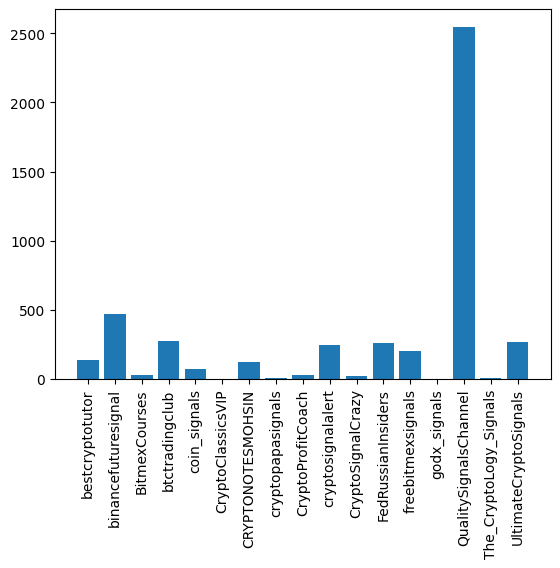

In [45]:
import pandas as pd
from matplotlib import pyplot as plt
count = []
names = []
for group in groups:
    names.append(group)
    count.append(len(tel_df[tel_df['Name']==group]))
plt.bar(names,count)
plt.xticks(rotation=90)
plt.show()

Before Filter 1

In [46]:
def extractor(i):
    i = str(i)
    suffixes = 'usdt|busd|futures'
    coinsregex = '|'.join(binance_coins)
    found = False
    text = re.sub(r'[^\w\s]', ' ', i)
    for s in text.split():
        if re.search("({})({})+|({})+({})|^({})$|[0-9]+({})|({})[0-9]+".format(coinsregex,suffixes,suffixes,coinsregex,coinsregex,coinsregex,coinsregex), s,re.IGNORECASE):
            found = True
            break
    if(found):
        return i
    else: return np.nan
tel_df['Cleaned Text'] = tel_df['Cleaned Text'].apply(extractor)
tel_df_fil1 = tel_df[tel_df['Cleaned Text'].notna()] 
tel_df_fil1

C:\Users\Mohib\AppData\Local\Temp\ipykernel_11984\1935579755.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tel_df['Cleaned Text'] = tel_df['Cleaned Text'].apply(extractor)


,Name,Timestamp,Text,Cleaned Text
4677,UltimateCryptoSignals,1680592302,#ADA #ADAUSDT (Binance)Buy Between 0.37 - 0.40...,ADA ADAUSDT BinanceBuy Between 0.37 - 0.40 Tar...
4668,UltimateCryptoSignals,1680740508,PAIR: APTUSDTTYPE: SHORTLEVERAGE: Cross 20 x E...,PAIR APTUSDTTYPE SHORTLEVERAGE Cross 20 x Entr...
4667,UltimateCryptoSignals,1680740528,PAIR: APTUSDT TYPE: SHORT LEVERAGE: Cross 20 x...,PAIR APTUSDT TYPE SHORT LEVERAGE Cross 20 x En...
4662,UltimateCryptoSignals,1680927499,#FET is compressed and if it breaks the trend ...,FET compressed break trend line up target avai...
4659,UltimateCryptoSignals,1681089012,PAIR: APEUSDTTYPE: LONGLEVERAGE: Cross 20 x En...,PAIR APEUSDTTYPE LONGLEVERAGE Cross 20 x Entry...
...,...,...,...,...
4,bestcryptotutor,1683031206,Signal Type Future/Spot Exchange Binance Coin ...,Signal Type FutureSpot Exchange Binance Coin G...
3,bestcryptotutor,1683075112,Signal Type Future/SpotExchange BinanceCoin (A...,Signal Type FutureSpotExchange BinanceCoin ALP...
2,bestcryptotutor,1683084098,Signal Type Future/Spot Exchange Binance Coin ...,Signal Type FutureSpot Exchange Binance Coin A...
1,bestcryptotutor,1683089124,Signal Type Future/Spot Exchange Binance Coin ...,Signal Type FutureSpot Exchange Binance Coin A...


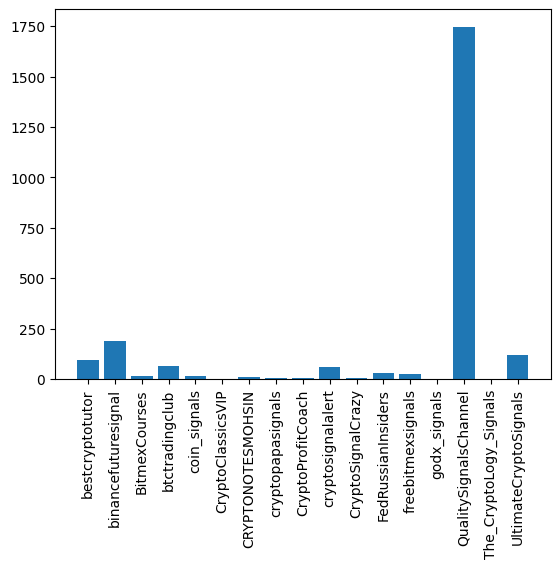

In [47]:
import pandas as pd
from matplotlib import pyplot as plt
count = list()
names = list()
for group in groups:
    names.append(group)
    count.append(len(tel_df_fil1[tel_df_fil1['Name']==group]))
plt.bar(names,count)
plt.xticks(rotation=90)
plt.show()

After Filter 1 

Change Write Mode to Append

In [48]:
os.chdir('C:\\Users\\Mohib\\Desktop\\Testing Channels')
if not os.path.exists('Channels'):
    os.mkdir('Channels')
os.chdir(os.path.join(os.getcwd(),'Channels'))
for i in groups:
    if not os.path.exists(i):
        os.mkdir(i)
    os.chdir(os.path.join(os.getcwd(),i))
    tel_df_fil1[tel_df_fil1['Name']==i].to_csv('1_'+i+'.csv', mode='w', index=False, header=False)
    os.chdir('C:\\Users\\Mohib\\Desktop\\Testing Channels\\Channels')
os.chdir("C:\\Users\\Mohib\\Desktop\\FinalYear\\Telegram")
with open('datetime.txt', 'w') as f:
    f.write(str(datetime.now()))